In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
from matplotlib import gridspec
import matplotlib.patches as mpatches

# adaptive-wavelets modules
from eval_biology import load_results, max_transformer, get_tensors, max_fun
from awave.data.biology import get_dataloader, load_pretrained_model
from awave.utils.misc import tuple_to_tensor, get_wavefun
from awave.trim import TrimModel
import awave
from umap import UMAP
from sklearn.decomposition import PCA

# evaluation
from eval_biology import load_results, max_transformer
from ex_biology import p

In [2]:
dirs = [
    "db5_saliency_warmstart_seed=1",
]
dics, results, models = load_results(dirs)

In [3]:
# load data
(train_loader, test_loader) = get_dataloader(p.data_path,
                                             batch_size=p.batch_size,
                                             is_continuous=True)

# cross validation
reg_score = []

for i, wt in enumerate(list(dics[0]['wt'].values())):
    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = max_transformer(wt,
                                               train_loader,
                                               test_loader,
                                               sgn="pos",
                                               m=6)

    clf = LinearRegression()
    scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
    reg_score.append(scores.mean())
reg_score = np.array(reg_score)

# select best wavelet
idx1, idx2 = list(dics[0]['wt'].keys())[np.argmax(reg_score).flatten()[0]]
wt = dics[0]['wt'][(idx1, idx2)]

# original wavelet transform
wt_o = awave.DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0)

In [4]:
# test data and wavelet coeffs
X_test = test_loader.dataset.tensors[0]
y_test = test_loader.dataset.tensors[1]
y_test = y_test.cpu().numpy().squeeze()
X1 = wt(X_test)
X2 = wt_o(X_test)

# umap
umap = UMAP(n_components=2, random_state=42)

# UMAP

In [6]:
# run t-SNE
n = 1005
idx = 0
d1 = X1[idx].detach().cpu().numpy().squeeze()
d2 = X2[idx].detach().cpu().numpy().squeeze()
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding = umap.fit_transform(d)

# run t-SNE
idx = 1
d1 = X1[idx].detach().cpu().numpy().squeeze()
d2 = X2[idx].detach().cpu().numpy().squeeze()
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding2 = umap.fit_transform(d)

In [7]:
# run t-SNE
idx = 2
d1 = X1[idx].detach().cpu().numpy().squeeze()
d2 = X2[idx].detach().cpu().numpy().squeeze()
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding3 = umap.fit_transform(d)

In [8]:
# run t-SNE
idx = 3
d1 = X1[idx].detach().cpu().numpy().squeeze()
d2 = X2[idx].detach().cpu().numpy().squeeze()
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding4 = umap.fit_transform(d)

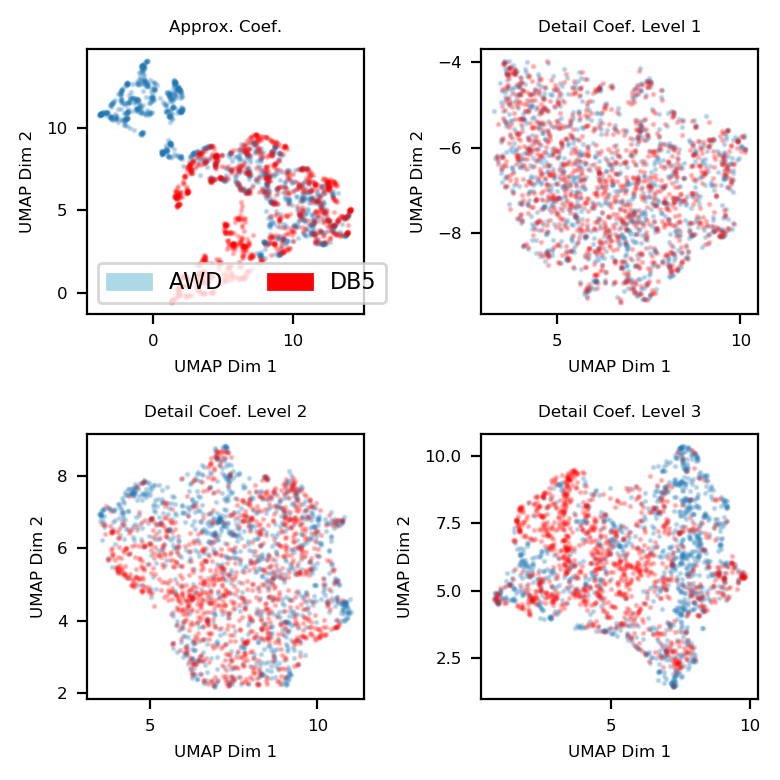

In [13]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['red', 'lightblue']
n = 1005

# embedding1 vs embedding2
f_ax1 = fig.add_subplot(spec[0, 0])

h1 = plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2) #, c=y_test, cmap='Blues')
h2 = plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, alpha=0.2, color='red') #, c=y_test, cmap='Reds')            
# plt.gca().set_aspect('equal', 'datalim')
blue_patch = mpatches.Patch(color='lightblue', label='AWD')
red_patch = mpatches.Patch(color='red', label='DB5')
plt.legend((h1, h2),
           ('AWD', 'DB5'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8,
           handles=(blue_patch, red_patch))
plt.title("Approx. Coef.", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)

# embedding1 vs embedding2
f_ax2 = fig.add_subplot(spec[0, 1])

b1 = plt.scatter(embedding2[:n, 0], embedding2[:n, 1], marker=".", s=5, alpha=0.2) #, c=y_test, cmap='Blues')
b2 = plt.scatter(embedding2[n:, 0], embedding2[n:, 1], marker=".", s=5, alpha=0.2, color='red') #, c=y_test, cmap='Reds')            
# plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Detail Coef. Level 1", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)
# plt.colorbar(b1)

# embedding1 vs embedding2
f_ax3 = fig.add_subplot(spec[1, 0])

plt.scatter(embedding3[:n, 0], embedding3[:n, 1], marker=".", s=5, alpha=0.2) #, c=y_test, cmap='Blues')
plt.scatter(embedding3[n:, 0], embedding3[n:, 1], marker=".", s=5, alpha=0.2, color='red') #, c=y_test, cmap='Reds')            
# plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Detail Coef. Level 2", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)

# embedding1 vs embedding2
f_ax4 = fig.add_subplot(spec[1, 1])

r1 = plt.scatter(embedding4[:n, 0], embedding4[:n, 1], marker=".", s=5, alpha=0.2) #, c=y_test, cmap='Blues')
r2 = plt.scatter(embedding4[n:, 0], embedding4[n:, 1], marker=".", s=5, alpha=0.2, color='red') #, c=y_test, cmap='Reds')            
# plt.gca().set_aspect('equal', 'datalim')
plt.title("Detail Coef. Level 3", fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
# plt.colorbar(r2)
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)
plt.tight_layout()
plt.show()